<a href="https://colab.research.google.com/github/tomerlieber/Multi-Label-Emotion-Regression/blob/main/Emotion%20Regression%20using%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural emotion detection using BERT


# 1. Setup

## 1.1. Using Colab GPU for training

In [ ]:
import torch

# If there's a GPU avaiable, tell PyTorch to use the GPU,
# otherwise, using the CPU instead.
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print('We will use the CPU because no GPU available.')

We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

Install the pytorch interface for BERT by Hugging Face.

In [ ]:
!pip install transformers

     |████████████████████████████████| 890kB 5.3MB/s 
     |████████████████████████████████| 3.0MB 15.2MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7199d295a91c63094eed8b92bb518a585e6f06ae1e3978bd889d803004a102e6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 2. Loading EmoBank Dataset

The dataset that we work on is called EmoBank, which comprises 10k sentences balancing multiple genres.

It's hosted on GitHub in this repo: https://github.com/JULIELab/EmoBank

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv('https://raw.githubusercontent.com/JULIELab/EmoBank/master/corpus/emobank.csv')

train_indexes = df.index[df['split'] == 'train'].tolist()
dev_indexes = df.index[df['split'] == 'dev'].tolist()
test_indexes = df.index[df['split'] == 'test'].tolist()

# Get the lists of sentences and their labels.
sentences = df.text.values
vad = df[['V', 'A', 'D']].values


# 3. Tokenization & Input Formatting

## 3.1. BERT Tokenizer

In [ ]:
from transformers import BertTokenizer, BertModel, AdamW

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

# Uncased means that the text has been lower cased before Word Piece
# tokenization, e.g., John Smith becomes john smith. The Uncased model also
# strips out any accent markers
bert_pretrained_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_pretrained_model_name)#, do_lower_case=True)

Loading BERT tokenizer...


## 3.2. Tokenize Dataset

Perform one tokenization pass of the dataset in order to measure the maximum sentence length

In [ ]:
def get_max_sentence_length(sentences):
  max_len = 0

  # For every sentence...
  for sent in sentences:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  return max_len

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

max_sentence_length = get_max_sentence_length(sentences)

# For every sentence...
for sentence in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      sentence,                         # Sentence to encode.
      add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
      max_length = max_sentence_length,             # Pad & truncate all sentences.
      truncation = True,            # Explicitely truncate sentences to max length.
      pad_to_max_length = True,
      return_attention_mask = True, # Construct attn. masks.
      return_tensors = 'pt',        # Return pytorch tensors.
      )
      
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])
  
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
outputs = torch.tensor(vad, dtype=torch.float32) # TODO: check if it's necessary


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, Subset, DataLoader

dataset = TensorDataset(input_ids, attention_masks, outputs)

train_dataset = Subset(dataset, train_indexes)
dev_dataset = Subset(dataset, dev_indexes)
test_dataset = Subset(dataset, test_indexes)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle = True, # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            shuffle = False, # Default: Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            shuffle = False, # Default: Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Model

## 4.1. Create a Bert model with a regression layer on top

In [ ]:
import torch.nn as nn

# Bert Model transformer with a sequence regression head on top (a linear
# layer on top of the pooled output).
class BertForSequenceRegression(nn.Module):
  def __init__(self, bert_pretrained_model_name, output_size):
    super(BertForSequenceRegression, self).__init__()
    self.bert = BertModel.from_pretrained(bert_pretrained_model_name,
                                          output_attentions = False,
                                          output_hidden_states = False)
    self.out = nn.Linear(self.bert.config.hidden_size, output_size)
    
  def forward(self, input_sentence, input_mask):
    last_hidden_states = self.bert(input_sentence, attention_mask=input_mask)[1]
    output = self.out(last_hidden_states)
    return output

model = BertForSequenceRegression(bert_pretrained_model_name, output_size=3)

# freeze some layers (top | middle | bottom):
bottom = range(2, 12)
middle = list(range(0,5))+list(range(7,12))
top = range(0, 10)

layersToFreeze = top
for i in layersToFreeze:
  print(i)
  for param in model.bert.encoder.layer[i].parameters():
    param.requires_grad = False

# Tell pytorch to run this model on the GPU
model.to(device)


0
1
2
3
4
5
6
7
8
9


BertForSequenceRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

## 4.2. Training Loop

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch.optim as optim

# Optimizer (ADAM is a fancy version of SGD) lr options: 2e-5, 3e-5, 5e-5
optimizer = optim.Adam(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 9

# Loss function
criterion = torch.nn.MSELoss()

# We'll store a number of quantities such as training loss and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
    
  # Perform one full pass over the training set.
  
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode.
  # Dropout layers behave differently during training vs. eval mode.
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using the 
    # `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # zero gradients
    optimizer.zero_grad()
    model.zero_grad()  

    # Perform a forward pass (evaluate the model on this training batch).
    output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))
      
    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in dev_dataloader:

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      
      # Perform a forward pass
      output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))

    # Accumulate the development loss.
    total_eval_loss += loss.item()

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(dev_dataloader)

  # Measure how long the development run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
          'Valid. Loss': avg_val_loss,
          'Validation Time': validation_time
      })
  
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 9 ========
Training...
  Batch    40  of    252.    Elapsed: 0:00:22.
  Batch    80  of    252.    Elapsed: 0:00:44.
  Batch   120  of    252.    Elapsed: 0:01:07.
  Batch   160  of    252.    Elapsed: 0:01:31.
  Batch   200  of    252.    Elapsed: 0:01:55.
  Batch   240  of    252.    Elapsed: 0:02:21.

  Average training loss: 0.86
  Training epcoh took: 0:02:29

Running Validation...
  Validation Loss: 0.07
  Validation took: 0:00:10

======== Epoch 2 / 9 ========
Training...
  Batch    40  of    252.    Elapsed: 0:00:25.
  Batch    80  of    252.    Elapsed: 0:00:50.
  Batch   120  of    252.    Elapsed: 0:01:16.
  Batch   160  of    252.    Elapsed: 0:01:41.
  Batch   200  of    252.    Elapsed: 0:02:06.
  Batch   240  of    252.    Elapsed: 0:02:31.

  Average training loss: 0.06
  Training epcoh took: 0:02:39

Running Validation...
  Validation Loss: 0.06
  Validation took: 0:00:10

======== Epoch 3 / 9 ========
Training...
  Batch    40  of    252.    Elapse

In [ ]:
import pandas as pd

# Display floats with three decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Training Time,Valid. Loss,Validation Time
epoch,,,,
1,0.8591,0:02:29,0.0737,0:00:10
2,0.0648,0:02:39,0.0625,0:00:10
3,0.0569,0:02:39,0.0577,0:00:10
4,0.0509,0:02:39,0.0549,0:00:10
5,0.0469,0:02:39,0.0527,0:00:10
6,0.0436,0:02:38,0.0517,0:00:10
7,0.0401,0:02:39,0.0487,0:00:10
8,0.0379,0:02:39,0.0523,0:00:10
9,0.0354,0:02:39,0.0476,0:00:10


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


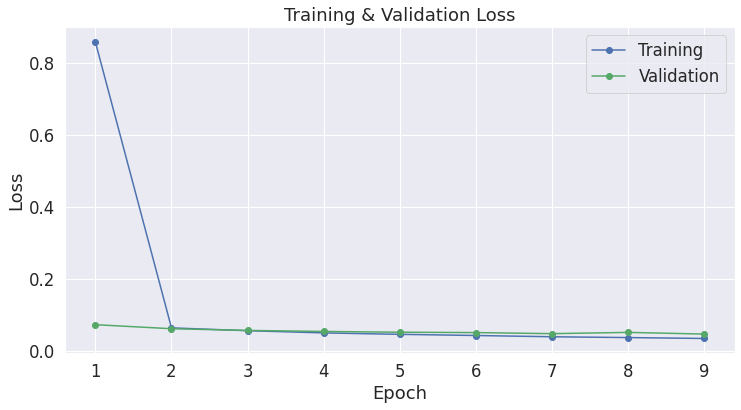

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.show()

# 5. Performance On Test Set

In [ ]:
# Prediction on test set

print('Predicting values for {:,} test sentences...'.format(len(test_dataloader.dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
total_test_loss = 0

# Predict 
for batch in test_dataloader:

  # Add batch to GPU
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    
    # Perform a forward pass
    output = model(b_input_ids, b_input_mask)

  # loss
  loss = criterion(output.view(-1), b_labels.view(-1))

  # Accumulate the development loss.
  total_test_loss += loss.item()

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

print(avg_test_loss)
print('    DONE.')

Predicting values for 1,000 test sentences...
0.046202459896449
    DONE.


# 6. Appendix
## Test the impact on the performance of freezing different layers in the BERT model

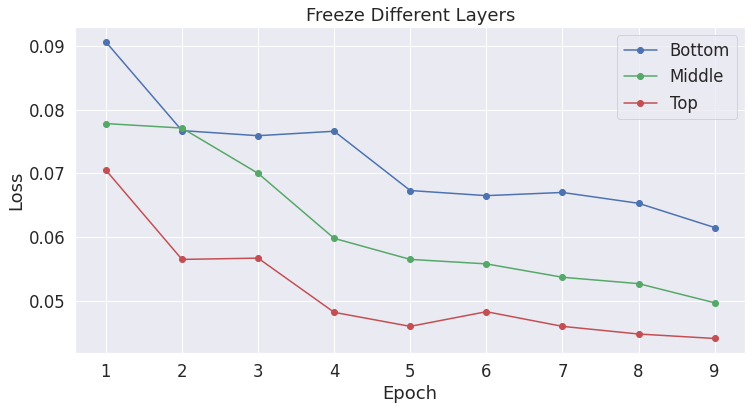

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

results = []

bottomResults = [0.0906, 0.0767, 0.0759, 0.0766, 0.0673, 0.0665, 0.0670, 0.0653, 0.0615]
middleResults = [0.0778, 0.0771, 0.0700, 0.0598, 0.0565, 0.0558, 0.0537, 0.0527, 0.0497]
topResults = [0.0705, 0.0565, 0.0567, 0.0482, 0.0460, 0.0483, 0.0460, 0.0448, 0.0441]
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for epoch_i in range(len(epochs)):
  results.append(
      {
          'epoch': epoch_i + 1,
          'Bottom': bottomResults[epoch_i],
          'Middle': middleResults[epoch_i],
          'Top': topResults[epoch_i]
      })

# Create a DataFrame from our training statistics.
results = pd.DataFrame(data=results)

# Use the 'epoch' as the row index.
results = results.set_index('epoch')

# Plot the learning curve.
plt.plot(results['Bottom'], 'b-o', label="Bottom")
plt.plot(results['Middle'], 'g-o', label="Middle")
plt.plot(results['Top'], 'r-o', label="Top")

# Label the plot.
plt.title("Freeze Different Layers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(epochs)

plt.show()